# Bias and Fairness Assessment (Binary Classification: Adult Income)

### Step 1: Install and import dependencies


In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [2]:
# fetch dataset
adult = fetch_ucirepo(id=2)
adult = adult.data.features.join(adult.data.targets, how="inner")

In [3]:
adult.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


## Basic Preprocessing Steps

### 1. Drop missing values

In [4]:
# Drop missing values
adult.dropna(inplace=True)

### 2. Copy DataFrame for posterity

In [5]:
df = adult.copy()

In [6]:
adult["income"].value_counts()

income
<=50K     24720
<=50K.    11360
>50K       7841
>50K.      3700
Name: count, dtype: int64

### 3. Encode categorical variables

In [7]:
def outcome_merge(val):
    if val == "<=50K" or val == "<=50K.":
        return 0
    else:
        return 1

In [8]:
df["income"] = df["income"].apply(outcome_merge)

In [9]:
#  sex, count and percentages above_50k

income_by_sex = df.groupby("sex")["income"].agg(
    ["count", lambda x: (x.sum() / x.count()) * 100]
)
income_by_sex.columns = ["count", "percentage_above_50k"]
income_by_sex

,count,percentage_above_50k
sex,,
Female,15684,11.068605
Male,31937,30.701068


In [10]:
#  race, count and percentages above_50k

income_by_race = df.groupby("race")["income"].agg(
    ["count", lambda x: (x.sum() / x.count()) * 100]
)
income_by_race.columns = ["count", "percentage_above_50k"]
income_by_race

,count,percentage_above_50k
race,,
Amer-Indian-Eskimo,460,11.956522
Asian-Pac-Islander,1447,27.436075
Black,4535,12.238148
Other,393,12.468193
White,40786,25.707351


In [11]:
df['race'] = df['race'].replace("Amer-Indian-Eskimo", "Native American or Inuit")

### 4. Split the data

In [12]:
# Split data
X = df.drop("income", axis=1)
y = df["income"]

In [13]:
for col in X.columns:
    if isinstance(X[col], object):
        X[col] = X[col].astype("category")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [15]:
y_train.value_counts()

income
0    28910
1     9186
Name: count, dtype: int64

## Train XGBoost Model

In [16]:
model = XGBClassifier(eval_metric="logloss", random_state=42, enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluate XGBoost Model

In [17]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7170
           1       0.77      0.64      0.70      2355

    accuracy                           0.86      9525
   macro avg       0.83      0.79      0.81      9525
weighted avg       0.86      0.86      0.86      9525



# Bias and Fairness Analysis with EquiBoots

**Equiboots supports a point estimate fairness analysis on a model's operating point (e.g., optimal threshold) as well as on multiple bootstraps with replacement.**


To initialize an analysis with equiboots:

1. Define a fairness Dataframe with the variables of interest.
2. Initialize an equiboots object using:
    - Ground truth (y_true)
    - Model probabilities (y_prob)
    - Model predictions (y_pred)
3. Identify the columns/variables that we will be assessing (e.g., race, sex)

In [18]:
import equiboots as eqb

In [19]:
# get predictions and true values
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
y_test = y_test.to_numpy()

X_test[['race', 'sex']] = X_test[['race', 'sex']].astype(str)

## Point Estimates

In [20]:
sensitive_features = ['race', 'sex']

fairness_df = X_test[sensitive_features].reset_index(drop=True)

eq = eqb.EquiBoots(y_true=y_test, y_pred=y_pred, y_prob=y_prob, fairness_df=fairness_df, fairness_vars=sensitive_features)

eq.grouper(groupings_vars=sensitive_features)

Groups created


In [21]:
sliced_race_data = eq.slicer("race")
sliced_sex_data = eq.slicer("sex")

race_metrics = eq.get_metrics(sliced_race_data)
sex_metrics = eq.get_metrics(sliced_sex_data)

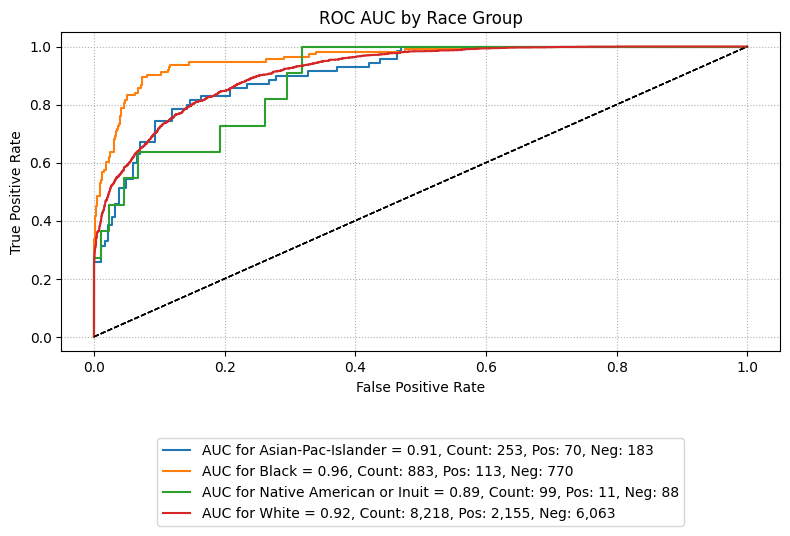

In [22]:
eqb.eq_plot_group_curves(
    sliced_race_data,
    curve_type="roc",
    title="ROC AUC by Race Group",
    exclude_groups=['Other']
)

In [23]:
test_config = {
    "test_type": "chi_square",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification"
}

In [24]:
stat_test_results_race = eq.analyze_statistical_significance(race_metrics, "race", test_config)

In [25]:
stat_test_results_sex = eq.analyze_statistical_significance(sex_metrics, "sex", test_config)

In [26]:
stat_test_results_sex

{'omnibus': StatTestResult(statistic=617.2827538245972, p_value=3.611329416979354e-133, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.2545713815966785, confidence_interval=None),
 'Female': StatTestResult(statistic=617.2827538245972, p_value=3.611329416979354e-133, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.2545713815966785, confidence_interval=None)}

In [27]:
race_metrics.pop('Other')

{'Accuracy': 0.9722222222222222,
 'Precision': 1.0,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.8,
 'Specificity': 1.0,
 'TP Rate': 0.6666666666666666,
 'FP Rate': 0.0,
 'FN Rate': 0.3333333333333333,
 'TN Rate': 1.0,
 'TP': 4,
 'FP': 0,
 'FN': 2,
 'TN': 66,
 'Prevalence': 0.08333333333333333,
 'Predicted Prevalence': 0.05555555555555555,
 'ROC AUC': 0.994949494949495,
 'Average Precision Score': 0.9583333333333334,
 'Log Loss': 0.07185231021677413,
 'Brier Score': 0.02028346858680295,
 'Calibration AUC': 0.24372879023686933}

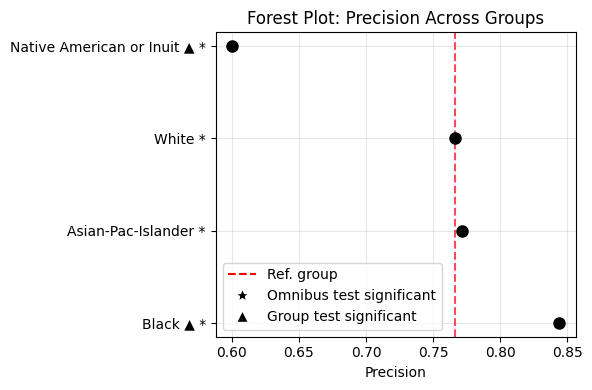

In [28]:
eqb.eq_plot_metrics_forest(
    group_metrics=race_metrics,
    metric_name="Precision",
    title="Forest Plot: Precision Across Groups",
    reference_group="White",
    statistical_tests=stat_test_results_race,
    
)

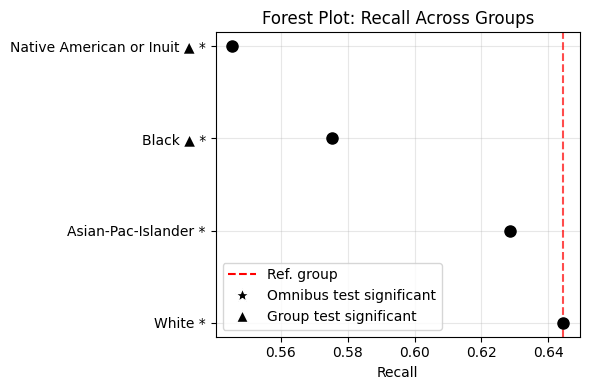

In [29]:
eqb.eq_plot_metrics_forest(
    group_metrics=race_metrics,
    metric_name="Recall",
    title="Forest Plot: Recall Across Groups",
    reference_group="White",
    statistical_tests=stat_test_results_race,
    
)

In [30]:
int_list = np.linspace(0, len(y_test), num=len(y_test), dtype=int).tolist()


In [31]:
eqb_bootstrap = eqb.EquiBoots(
    y_true=y_test,
    y_pred=y_pred,
    y_prob=y_prob,
    fairness_df=fairness_df,
    fairness_vars=['race'],
    seeds=int_list,
    reference_groups=['White'],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=5001,
    boot_sample_size=len(y_test),
    stratify_by_outcome=True,
    balanced=True,
    )

In [32]:
print(eqb_bootstrap.seeds)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [33]:
eqb_bootstrap.grouper(groupings_vars=['race'])

Bootstrapping iterations:   0%|          | 0/5001 [00:00<?, ?it/s]/home/afunnell/Code/EquiBoots/equi_boots/src/equiboots/EquiBootsClass.py:98: UserWarning: Group 'Other' for variable 'race' has less than 10 samples. Skipping category of this group.
  warnings.warn(
Bootstrapping iterations: 100%|██████████| 5001/5001 [01:38<00:00, 50.95it/s]

Groups created


In [34]:
bootstrap_race_data = eqb_bootstrap.slicer("race")

/home/afunnell/Code/EquiBoots/equi_boots/src/equiboots/EquiBootsClass.py:331: UserWarning: Group 'Other' for variable 'race' has less than 10 samples. Skipping catategory of this group.
  warnings.warn(


In [35]:
boots_race_metrics = eqb_bootstrap.get_metrics(bootstrap_race_data)

Calculating metrics for each bootstrap:


100%|██████████| 5001/5001 [02:37<00:00, 31.78it/s]


In [36]:
diffs = eqb_bootstrap.calculate_differences(boots_race_metrics, "race")

In [37]:
diffs

[{'White': {'Accuracy_diff': 0.0,
   'Precision_diff': 0.0,
   'Recall_diff': 0.0,
   'F1_Score_diff': 0.0,
   'Specificity_diff': 0.0,
   'TP_Rate_diff': 0.0,
   'FP_Rate_diff': 0.0,
   'FN_Rate_diff': 0.0,
   'TN_Rate_diff': 0.0,
   'Prevalence_diff': 0.0,
   'Predicted_Prevalence_diff': 0.0,
   'ROC_AUC_diff': 0.0,
   'Average_Precision_Score_diff': 0.0,
   'Log_Loss_diff': 0.0,
   'Brier_Score_diff': 0.0,
   'Calibration_AUC_diff': 0.0},
  'Black': {'Accuracy_diff': 0.0005249343832021136,
   'Precision_diff': 0.07431414706532902,
   'Recall_diff': -0.055118110236220486,
   'F1_Score_diff': -0.016709709254263183,
   'Specificity_diff': 0.05616797900262471,
   'TP_Rate_diff': -0.055118110236220486,
   'FP_Rate_diff': -0.05616797900262467,
   'FN_Rate_diff': 0.055118110236220486,
   'TN_Rate_diff': 0.05616797900262471,
   'Prevalence_diff': 0.0,
   'Predicted_Prevalence_diff': -0.0556430446194226,
   'ROC_AUC_diff': 0.049902246471159595,
   'Average_Precision_Score_diff': 0.0463600587

In [38]:
diifs = eqb_bootstrap.calculate_differences(boots_race_metrics, "race")

In [39]:
diffs = eqb_bootstrap.calculate_differences(boots_race_metrics, "race")

In [40]:
# metrics to perform a statistical test
metrics_boot = [

    "F1_Score_diff",
    "ROC_AUC_diff",
    "Average_Precision_Score_diff",
]

# configuration dictionary to provide parameters around statistical testing
test_config = {
    "test_type": "bootstrap_test",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
    "tail_type": "two_tailed",
    "metrics": metrics_boot,
}


stat_test_results = eq.analyze_statistical_significance(
    metric_dict=boots_race_metrics,  # pass variable sliced metrics
    var_name="race",  # variable name
    test_config=test_config,  # configuration
    differences=diffs,  # the differences of each race group
)

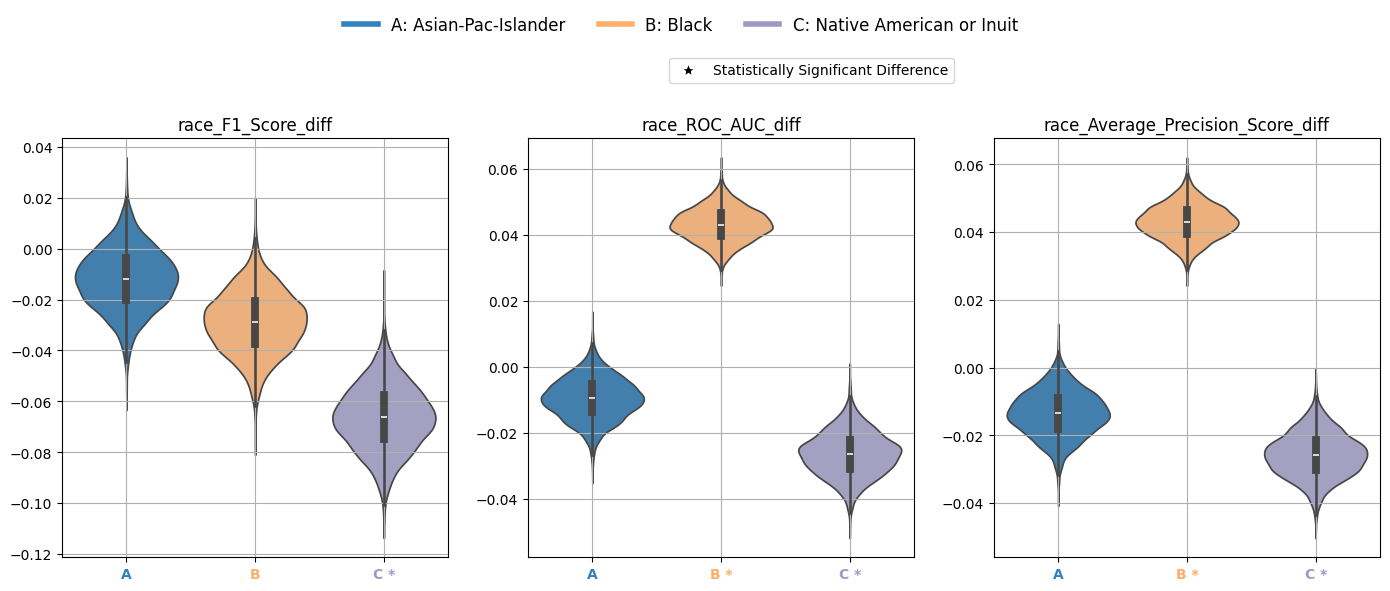

In [41]:
eqb.eq_group_metrics_plot(
    group_metrics=diffs,
    metric_cols=metrics_boot,
    name="race",
    categories="all",
    figsize=(14,5),
    plot_type="violinplot",
    color_by_group=True,
    show_grid=True,
    max_cols=3,
    statistical_tests=stat_test_results,
)

In [42]:
group_thresholds_sex = eqb.find_group_thresholds(
    y_true=y_test,
    y_prob=y_prob,
    reference_group='Male',
    group_vec=fairness_df['sex'],
    threshold_range=(0.1, 0.9),
    n_steps=100,
    default_threshold=0.5
)

In [43]:
group_thresholds_race = eqb.find_group_thresholds(
    y_true=y_test,
    y_prob=y_prob,
    reference_group='White',
    group_vec=fairness_df['race'],
    threshold_range=(0.1, 0.9),
    n_steps=100,
    default_threshold=0.5
)

In [44]:
sex_labels = fairness_df["sex"].values
race_labels = fairness_df["race"].values
y_pred_grouped_thresh = eqb.grouped_threshold_predict(y_prob, sex_labels, group_thresholds_sex)
y_pred_grouped_thresh_race = eqb.grouped_threshold_predict(y_prob, race_labels, group_thresholds_race)

In [45]:
eq_adjusted = eqb.EquiBoots(
    y_true=y_test,                        
    y_prob=y_prob,                        
    y_pred=y_pred_grouped_thresh_race,        
    fairness_df=fairness_df,                             
    fairness_vars=["race", "sex"],
    group_min_size=90
)

eq_adjusted.grouper(groupings_vars=["race", "sex"])


Groups created


/home/afunnell/Code/EquiBoots/equi_boots/src/equiboots/EquiBootsClass.py:98: UserWarning: Group 'Other' for variable 'race' has less than 90 samples. Skipping category of this group.
  warnings.warn(


In [46]:
# Extract subgroup data by race
sliced_race_data_adjusted = eq_adjusted.slicer("race")
sliced_sex_data_adjusted = eq_adjusted.slicer("sex")

# Compute fairness performance metrics for each racial group using adjusted predictions
sex_metrics_adjusted = eq_adjusted.get_metrics(sliced_sex_data_adjusted)
race_metrics_adjusted = eq_adjusted.get_metrics(sliced_race_data_adjusted)


/home/afunnell/Code/EquiBoots/equi_boots/src/equiboots/EquiBootsClass.py:331: UserWarning: Group 'Other' for variable 'race' has less than 90 samples. Skipping catategory of this group.
  warnings.warn(


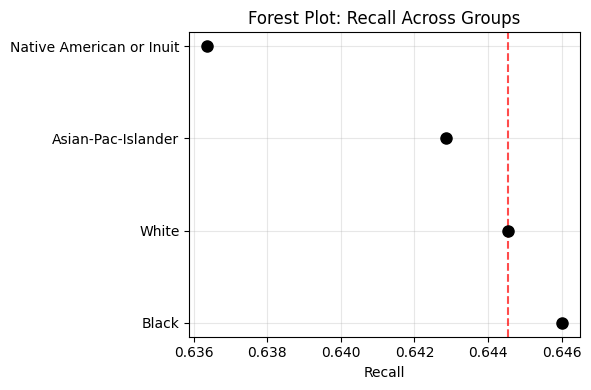

In [47]:
eqb.eq_plot_metrics_forest(
    group_metrics=race_metrics_adjusted,
    metric_name="Recall",
    title="Forest Plot: Recall Across Groups",
    reference_group="White",
)

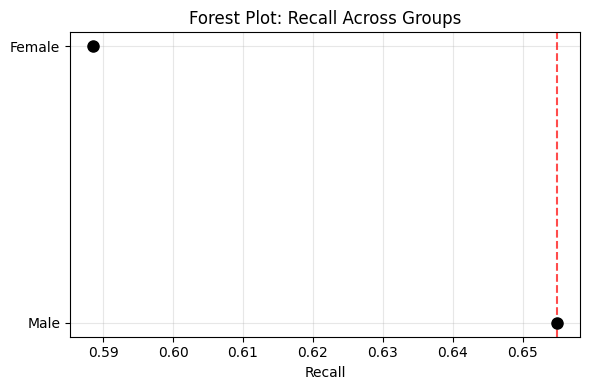

In [48]:
eqb.eq_plot_metrics_forest(
    group_metrics=sex_metrics_adjusted,
    metric_name="Recall",
    title="Forest Plot: Recall Across Groups",
    reference_group="Male",
)